
# Transportation & Route Planning — Solution Notebook 



## STEP 0A — Load and Inspect Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# If running on Colab:
# !pip -q install pulp

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, value, LpStatus

# TODO: Load dataset
# Upload the CSV to Colab OR mount drive, then set the correct path here.

CSV_PATH = "https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/transport_route_planning_or.csv"  # Colab upload path
df_raw = pd.read_csv(CSV_PATH)

df_raw.head(), df_raw.shape, df_raw.columns


print("df shape:", df_raw.shape)
print("df column names: ",df_raw.columns)
df_raw.head()

df shape: (182, 17)
df column names:  Index(['order_id', 'ship_date', 'origin_node', 'destination_node',
       'order_qty_units', 'distance_km', 'planned_travel_time_hr',
       'actual_travel_time_hr', 'dispatch_policy', 'vehicle_id', 'route_id',
       'vehicle_capacity_units', 'fixed_trip_cost_eur',
       'variable_cost_per_km_eur', 'planned_departure_hour',
       'delivery_window_hr', 'on_time_flag'],
      dtype='object')


,order_id,ship_date,origin_node,destination_node,order_qty_units,distance_km,planned_travel_time_hr,actual_travel_time_hr,dispatch_policy,vehicle_id,route_id,vehicle_capacity_units,fixed_trip_cost_eur,variable_cost_per_km_eur,planned_departure_hour,delivery_window_hr,on_time_flag
0,O00001,2026-01-05,DC_Erlangen,CUST_14,244,161.3,3.15,3.95,4hr_Consolidate,TRUCK_4,20260105_TRUCK_4,1200,95,0.80,9,4,1
1,O00002,2026-01-05,DC_Erlangen,CUST_09,165,106.5,3.33,3.63,Immediate,TRUCK_1,20260105_TRUCK_1,1200,110,0.87,8,8,1
2,O00003,2026-01-05,DC_Erlangen,CUST_10,577,123.5,2.07,2.37,Immediate,TRUCK_3,20260105_TRUCK_3,1200,95,0.92,7,8,0
3,O00004,2026-01-05,DC_Erlangen,CUST_01,55,39.0,0.85,1.65,Immediate,TRUCK_1,20260105_TRUCK_1,1200,95,0.93,8,5,1
4,O00005,2026-01-05,DC_Erlangen,CUST_16,90,172.4,4.71,4.71,Immediate,TRUCK_1,20260105_TRUCK_1,1200,110,0.86,7,8,1


## STEP 0B — Identify Variable Roles

In [3]:
roles = {
    "FLOW": ["order_id","ship_date","origin_node","destination_node","order_qty_units","distance_km",
             "planned_travel_time_hr","actual_travel_time_hr","vehicle_id","route_id","dispatch_policy"],
    "COST": ["fixed_trip_cost_eur","variable_cost_per_km_eur"],
    "CAPACITY": ["vehicle_capacity_units"],
    "SERVICE": ["planned_departure_hour","delivery_window_hr","on_time_flag","delivery_window_hr"]
}
roles


{'FLOW': ['order_id',
  'ship_date',
  'origin_node',
  'destination_node',
  'order_qty_units',
  'distance_km',
  'planned_travel_time_hr',
  'actual_travel_time_hr',
  'vehicle_id',
  'route_id',
  'dispatch_policy'],
 'COST': ['fixed_trip_cost_eur', 'variable_cost_per_km_eur'],
 'CAPACITY': ['vehicle_capacity_units'],
 'SERVICE': ['planned_departure_hour',
  'delivery_window_hr',
  'on_time_flag',
  'delivery_window_hr']}

## STEP 1A — Identify Data Feasibility Issues (SEE)

In [4]:
dup_cnt = df_raw.duplicated(subset=["order_id","ship_date"], keep=False).sum()
missing_rate = df_raw.isna().mean().sort_values(ascending=False)
invalid_dist_cnt = (df_raw["distance_km"] <= 0).sum()

dup_cnt, missing_rate.head(12), invalid_dist_cnt


(4,
 planned_travel_time_hr      0.016484
 order_id                    0.000000
 vehicle_id                  0.000000
 delivery_window_hr          0.000000
 planned_departure_hour      0.000000
 variable_cost_per_km_eur    0.000000
 fixed_trip_cost_eur         0.000000
 vehicle_capacity_units      0.000000
 route_id                    0.000000
 dispatch_policy             0.000000
 ship_date                   0.000000
 actual_travel_time_hr       0.000000
 dtype: float64,
 1)

In [19]:
df_raw[df_raw["distance_km"] <= 0]

,order_id,ship_date,origin_node,destination_node,order_qty_units,distance_km,planned_travel_time_hr,actual_travel_time_hr,dispatch_policy,vehicle_id,route_id,vehicle_capacity_units,fixed_trip_cost_eur,variable_cost_per_km_eur,planned_departure_hour,delivery_window_hr,on_time_flag
157,O00158,2026-01-15,DC_Nuremberg,CUST_16,472,-179.2,4.73,5.53,Immediate,TRUCK_1,20260115_TRUCK_1,1200,110,0.8,9,8,1


## STEP 1B — Data Treatment (TREAT)

In [5]:
df_treat = df_raw.copy()

df_treat = df_treat.drop_duplicates(subset=["order_id","ship_date"], keep="first")
df_treat = df_treat[df_treat["distance_km"] > 0].copy()

assumed_speed_kmph = 60
mask = df_treat["planned_travel_time_hr"].isna()
df_treat.loc[mask, "planned_travel_time_hr"] = df_treat.loc[mask, "distance_km"] / assumed_speed_kmph

df_treat.shape, df_treat.isna().mean().sort_values(ascending=False).head(10)


((179, 17),
 order_id                    0.0
 vehicle_id                  0.0
 delivery_window_hr          0.0
 planned_departure_hour      0.0
 variable_cost_per_km_eur    0.0
 fixed_trip_cost_eur         0.0
 vehicle_capacity_units      0.0
 route_id                    0.0
 dispatch_policy             0.0
 ship_date                   0.0
 dtype: float64)

In [ ]:
df_raw[df_raw["order_id"] <= 0]

## STEP 2A — Construct Route-Level Cost Logic

In [6]:
df_treat["variable_cost_line_eur"] = df_treat["distance_km"] * df_treat["variable_cost_per_km_eur"]
df_treat[["distance_km","variable_cost_per_km_eur","variable_cost_line_eur"]].head()


,distance_km,variable_cost_per_km_eur,variable_cost_line_eur
0,161.3,0.80,129.040
1,106.5,0.87,92.655
2,123.5,0.92,113.620
3,39.0,0.93,36.270
4,172.4,0.86,148.264


## STEP 2B — Construct Utilization & Feasibility

In [7]:
rt_preview = (df_treat.groupby(["route_id","vehicle_id"], as_index=False)
             .agg(route_load=("order_qty_units","sum"),
                  cap=("vehicle_capacity_units","max"),
                  fixed_cost=("fixed_trip_cost_eur","max"),
                  var_cost=("variable_cost_line_eur","sum")))
rt_preview["utilization"] = rt_preview["route_load"] / rt_preview["cap"]
rt_preview["over_capacity"] = (rt_preview["route_load"] > rt_preview["cap"]).astype(int)
rt_preview["route_cost_eur"] = rt_preview["fixed_cost"] + rt_preview["var_cost"]

rt_preview.sort_values("utilization", ascending=False).head(10)


,route_id,vehicle_id,route_load,cap,fixed_cost,var_cost,utilization,over_capacity,route_cost_eur
14,20260107_TRUCK_5,TRUCK_5,2636,1200,130,735.738,2.196667,1,865.738
35,20260112_TRUCK_2,TRUCK_2,2341,1200,130,837.599,1.950833,1,967.599
2,20260105_TRUCK_3,TRUCK_3,1972,1200,110,312.021,1.643333,1,422.021
28,20260110_TRUCK_5,TRUCK_5,1653,1200,130,447.527,1.377500,1,577.527
23,20260109_TRUCK_5,TRUCK_5,1650,1200,110,729.929,1.375000,1,839.929
41,20260113_TRUCK_3,TRUCK_3,1630,1200,130,621.322,1.358333,1,751.322
15,20260108_TRUCK_1,TRUCK_1,1567,1200,130,526.528,1.305833,1,656.528
17,20260108_TRUCK_4,TRUCK_4,1551,1200,110,567.260,1.292500,1,677.260
47,20260114_TRUCK_4,TRUCK_4,1480,1200,130,516.887,1.233333,1,646.887
56,20260116_TRUCK_3,TRUCK_3,1443,1200,110,542.386,1.202500,1,652.386


## STEP 2C — Construct Service KPI

In [8]:
df_treat["on_time_recalc"] = (df_treat["actual_travel_time_hr"] <= df_treat["delivery_window_hr"]).astype(int)
(df_treat[["on_time_flag","on_time_recalc"]].value_counts().head(10))


on_time_flag  on_time_recalc
1             1                 165
0             0                  10
              1                   4
Name: count, dtype: int64

## STEP 3A — Build Baseline KPI Table

In [9]:
def kpi_summary(df: pd.DataFrame, route_col: str = "route_id") -> dict:
    d = df.copy()
    # Ensure unique column names
    d = d.loc[:, ~d.columns.duplicated()]

    d["on_time_kpi"] = d["on_time_recalc"] if "on_time_recalc" in d.columns else d["on_time_flag"]

    rt = (d.groupby([route_col], as_index=False)
            .agg(route_load=("order_qty_units","sum"),
                 cap=("vehicle_capacity_units","max"),
                 fixed_cost=("fixed_trip_cost_eur","max"),
                 var_cost=("variable_cost_line_eur","sum")))

    rt["utilization"] = rt["route_load"] / rt["cap"]
    rt["over_capacity"] = (rt["route_load"] > rt["cap"]).astype(int)
    rt["route_cost_eur"] = rt["fixed_cost"] + rt["var_cost"]

    orders = int(d["order_id"].nunique())
    routes = int(rt[route_col].nunique())
    total_cost = float(rt["route_cost_eur"].sum())
    cost_per_order = float(total_cost / orders) if orders else np.nan
    avg_util = float(rt["utilization"].mean()) if len(rt) else np.nan
    on_time_rate = float(d["on_time_kpi"].mean()) if len(d) else np.nan
    pct_over = float(rt["over_capacity"].mean()) if len(rt) else np.nan

    return {
        "orders": orders,
        "routes": routes,
        "total_cost_eur": total_cost,
        "cost_per_order_eur": cost_per_order,
        "avg_utilization": avg_util,
        "on_time_rate": on_time_rate,
        "pct_over_capacity_routes": pct_over
    }

baseline = kpi_summary(df_treat, route_col="route_id")
baseline


{'orders': 179,
 'routes': 58,
 'total_cost_eur': 25169.214,
 'cost_per_order_eur': 140.6101340782123,
 'avg_utilization': 0.7319827586206896,
 'on_time_rate': 0.9441340782122905,
 'pct_over_capacity_routes': 0.20689655172413793}

## STEP 3B — Diagnose Transportation Inefficiencies

In [10]:
rt = (df_treat.groupby(["route_id","vehicle_id"], as_index=False)
      .agg(route_load=("order_qty_units","sum"),
           cap=("vehicle_capacity_units","max"),
           fixed_cost=("fixed_trip_cost_eur","max"),
           var_cost=("variable_cost_line_eur","sum"),
           policy=("dispatch_policy","first")))
rt["utilization"] = rt["route_load"]/rt["cap"]
rt["over_capacity"] = (rt["route_load"] > rt["cap"]).astype(int)
rt["route_cost_eur"] = rt["fixed_cost"] + rt["var_cost"]

{
    "pct_low_util_routes_lt_70pct": float((rt["utilization"] < 0.70).mean()),
    "pct_over_capacity_routes": float(rt["over_capacity"].mean()),
    "avg_utilization": float(rt["utilization"].mean())
}


{'pct_low_util_routes_lt_70pct': 0.46551724137931033,
 'pct_over_capacity_routes': 0.20689655172413793,
 'avg_utilization': 0.7319827586206896}

## STEP 4A — OR Decision Framing (Provided Tool)


Read this carefully.

Decision  
Assign each order-line to exactly one truck (for that day).

Objective (business)  
Reduce the number of trucks used (fixed cost proxy) and reduce variable distance cost.

Constraints (business)  
Every order must be assigned once.  
No truck exceeds capacity.  
If a truck has any orders, it is considered “used”.


In [11]:
def solve_day(df_day: pd.DataFrame, truck_ids, capacity: int, fixed_cost: float = 110.0):
    orders = df_day.index.tolist()
    trucks = list(truck_ids)

    model = LpProblem("AssignDay", LpMinimize)
    x = LpVariable.dicts("x", (orders, trucks), 0, 1, LpBinary)
    y = LpVariable.dicts("y", trucks, 0, 1, LpBinary)

    var_cost = {i: float(df_day.loc[i,"distance_km"] * df_day.loc[i,"variable_cost_per_km_eur"]) for i in orders}

    model += fixed_cost * lpSum(y[v] for v in trucks) + lpSum(var_cost[i] * x[i][v] for i in orders for v in trucks)

    for i in orders:
        model += lpSum(x[i][v] for v in trucks) == 1

    for v in trucks:
        for i in orders:
            model += x[i][v] <= y[v]

    for v in trucks:
        model += lpSum(float(df_day.loc[i,"order_qty_units"]) * x[i][v] for i in orders) <= capacity

    status = model.solve()
    if LpStatus[status] != "Optimal":
        return None

    assign = {}
    for i in orders:
        for v in trucks:
            if value(x[i][v]) > 0.5:
                assign[i] = v
                break
    return assign


## STEP 4B — OR-Assisted Reassignment

In [12]:
truck_ids = ["TRUCK_1","TRUCK_2","TRUCK_3","TRUCK_4","TRUCK_5"]
capacity = 1200
fixed_cost = 110

df_or = df_treat.copy()
df_or["or_vehicle_id"] = None

for day, df_day in df_or.groupby("ship_date"):
    assign = solve_day(df_day, truck_ids=truck_ids, capacity=capacity, fixed_cost=fixed_cost)
    if assign is None:
        raise RuntimeError(f"Day {day} infeasible. Add trucks or increase capacity.")
    for idx, v in assign.items():
        df_or.at[idx, "or_vehicle_id"] = v

ship_date_dt = pd.to_datetime(df_or["ship_date"], errors="coerce")
df_or["or_route_id"] = ship_date_dt.dt.strftime("%Y%m%d") + "_" + df_or["or_vehicle_id"].astype(str)

df_or[["ship_date","or_vehicle_id","or_route_id"]].head()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/envs/argos_env/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/6673bbc18d9b42f7b0e480685ba1aae8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/6673bbc18d9b42f7b0e480685ba1aae8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 100 COLUMNS
At line 641 RHS
At line 737 BOUNDS
At line 818 ENDATA
Problem MODEL has 95 rows, 80 columns and 300 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1327.33 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0004I processed model has 95 rows, 80 columns (80 integer (80 of which binary)) and 305 elements
Cutoff increment increased from 1e-05 to 0.000999
Cbc0038I Initial

,ship_date,or_vehicle_id,or_route_id
0,2026-01-05,TRUCK_3,20260105_TRUCK_3
1,2026-01-05,TRUCK_4,20260105_TRUCK_4
2,2026-01-05,TRUCK_1,20260105_TRUCK_1
3,2026-01-05,TRUCK_3,20260105_TRUCK_3
4,2026-01-05,TRUCK_4,20260105_TRUCK_4


## STEP 4C — Recompute KPIs After OR (Fixed)

In [13]:
df_or_eval = df_or.copy()

# FIX: prevent duplicate 'route_id' columns (common cause of groupby error)
if "route_id" in df_or_eval.columns:
    df_or_eval = df_or_eval.drop(columns=["route_id"])
df_or_eval["route_id"] = df_or_eval["or_route_id"]

df_or_eval = df_or_eval.loc[:, ~df_or_eval.columns.duplicated()]

after_or = kpi_summary(df_or_eval, route_col="route_id")
after_or


{'orders': 179,
 'routes': 49,
 'total_cost_eur': 24284.214,
 'cost_per_order_eur': 135.666,
 'avg_utilization': 0.8664285714285715,
 'on_time_rate': 0.9441340782122905,
 'pct_over_capacity_routes': 0.0}

## STEP 5A — KPI Comparison (Before vs After)

In [14]:
comparison = pd.DataFrame([baseline, after_or], index=["Baseline","After_OR"])
comparison


,orders,routes,total_cost_eur,cost_per_order_eur,avg_utilization,on_time_rate,pct_over_capacity_routes
Baseline,179,58,25169.214,140.610134,0.731983,0.944134,0.206897
After_OR,179,49,24284.214,135.666000,0.866429,0.944134,0.000000


## STEP 5B — Route Feasibility Check

In [15]:
comparison[["routes","total_cost_eur","cost_per_order_eur","avg_utilization","on_time_rate","pct_over_capacity_routes"]]


,routes,total_cost_eur,cost_per_order_eur,avg_utilization,on_time_rate,pct_over_capacity_routes
Baseline,58,25169.214,140.610134,0.731983,0.944134,0.206897
After_OR,49,24284.214,135.666000,0.866429,0.944134,0.000000


## STEP 5C — Visual Comparison (KPI panels + network)

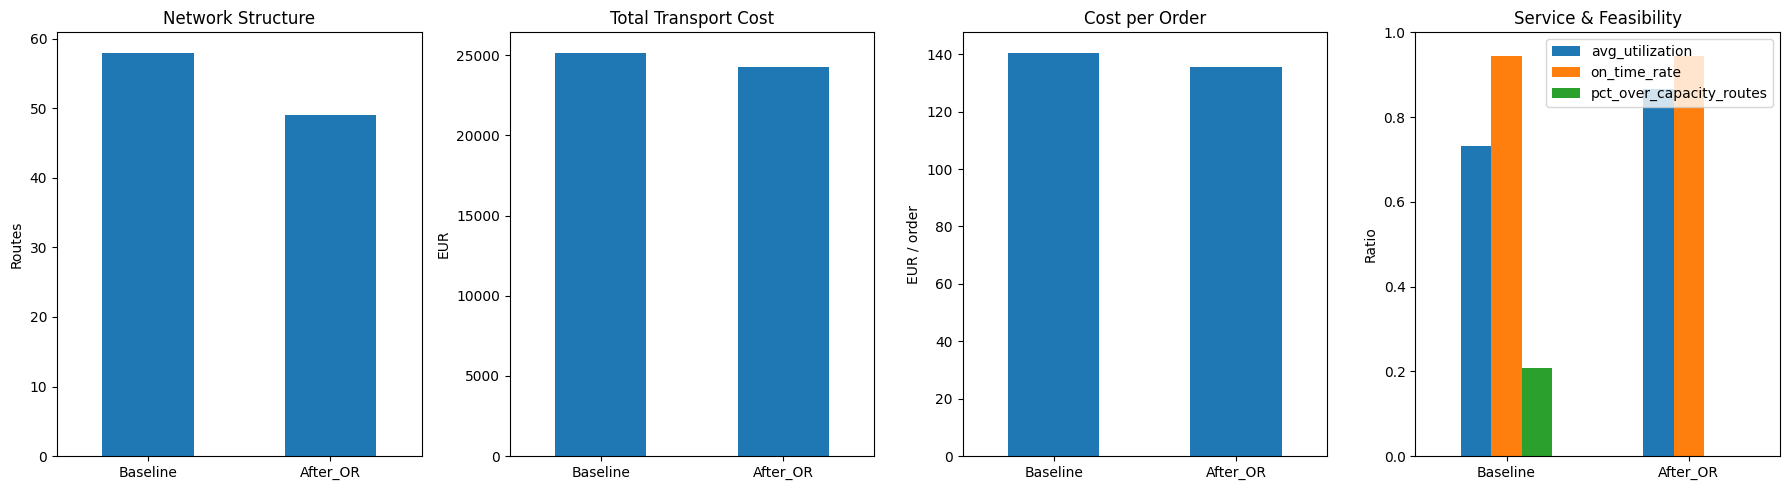

In [16]:
def plot_kpi_panels(comp: pd.DataFrame):
    fig, axs = plt.subplots(1, 4, figsize=(18,5))

    comp[["routes"]].plot(kind="bar", ax=axs[0], legend=False)
    axs[0].set_title("Network Structure")
    axs[0].set_ylabel("Routes")
    axs[0].set_xticklabels(comp.index, rotation=0)

    comp[["total_cost_eur"]].plot(kind="bar", ax=axs[1], legend=False)
    axs[1].set_title("Total Transport Cost")
    axs[1].set_ylabel("EUR")
    axs[1].set_xticklabels(comp.index, rotation=0)

    comp[["cost_per_order_eur"]].plot(kind="bar", ax=axs[2], legend=False)
    axs[2].set_title("Cost per Order")
    axs[2].set_ylabel("EUR / order")
    axs[2].set_xticklabels(comp.index, rotation=0)

    comp[["avg_utilization","on_time_rate","pct_over_capacity_routes"]].plot(kind="bar", ax=axs[3])
    axs[3].set_title("Service & Feasibility")
    axs[3].set_ylabel("Ratio")
    axs[3].set_ylim(0, 1)
    axs[3].set_xticklabels(comp.index, rotation=0)

    plt.tight_layout()
    plt.show()

plot_kpi_panels(comparison)


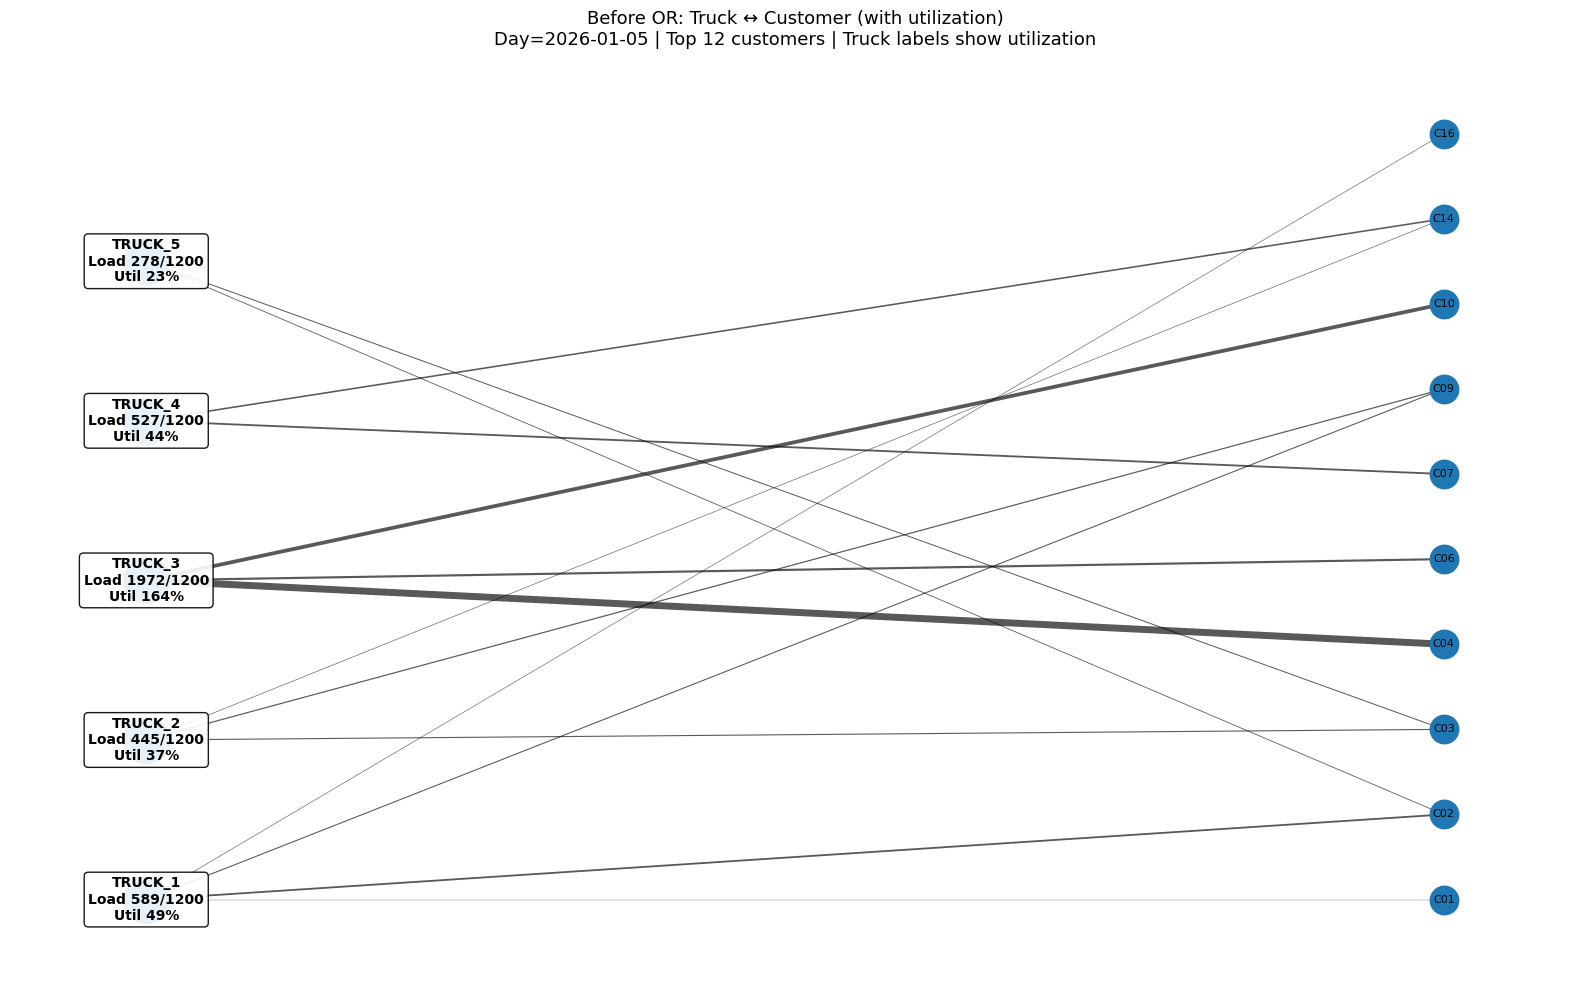

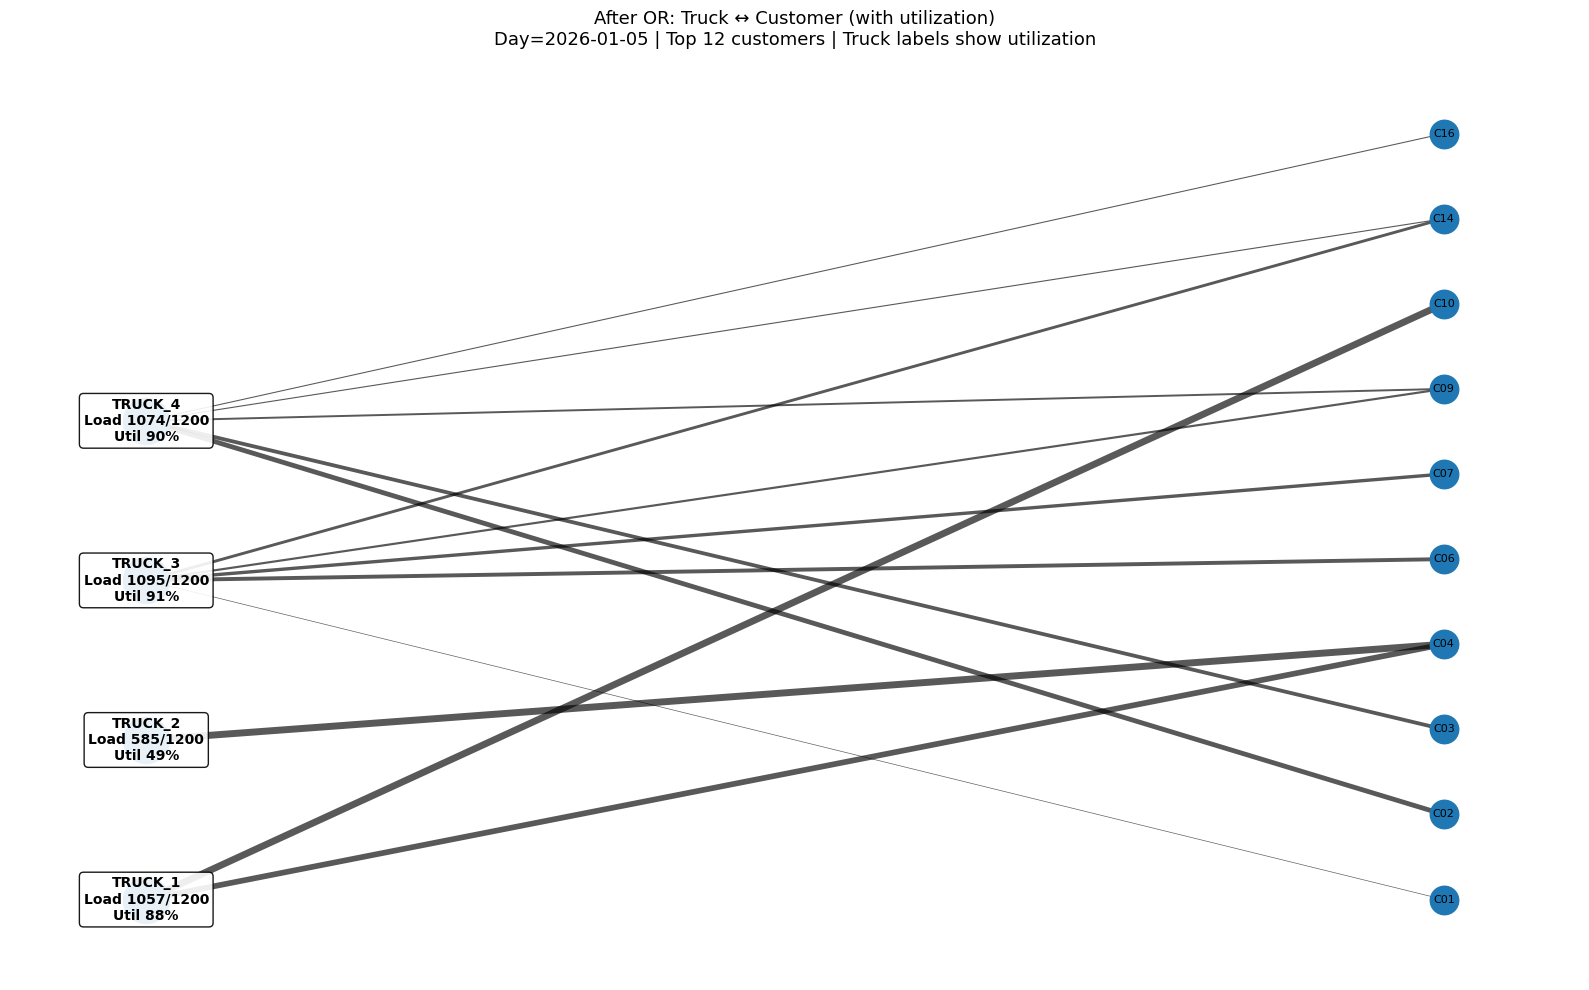

In [17]:
def plot_bipartite_day_with_util(df, day, vehicle_col, title, top_n_customers=12, capacity_col="vehicle_capacity_units"):
    d = df[df["ship_date"] == day].copy()
    if d.empty:
        raise ValueError(f"No rows found for day={day}")

    cust_rank = (d.groupby("destination_node")["order_qty_units"].sum().sort_values(ascending=False))
    top_custs = cust_rank.head(top_n_customers).index.tolist()
    d = d[d["destination_node"].isin(top_custs)].copy()

    truck_day = (d.groupby(vehicle_col, as_index=False)
                   .agg(load=("order_qty_units","sum"),
                        cap=(capacity_col,"max")))
    truck_day["util"] = truck_day["load"] / truck_day["cap"]

    trucks = sorted(truck_day[vehicle_col].dropna().unique().tolist())
    custs  = sorted(d["destination_node"].dropna().unique().tolist())

    G = nx.Graph()
    G.add_nodes_from(trucks, bipartite=0)
    G.add_nodes_from(custs,  bipartite=1)

    agg = (d.groupby([vehicle_col, "destination_node"], as_index=False)
             .agg(qty=("order_qty_units","sum")))

    for _, r in agg.iterrows():
        G.add_edge(r[vehicle_col], r["destination_node"], weight=float(r["qty"]))

    pos = {}
    for i, t in enumerate(trucks):
        pos[t] = (0, i * 1.5)
    for j, c in enumerate(custs):
        pos[c] = (4, j * 0.8)

    weights = [G[u][v]["weight"] for u, v in G.edges()]
    w_scaled = [(w / max(weights) * 5) if weights else 1 for w in weights]

    truck_label_map = {r[vehicle_col]: f"{r[vehicle_col]}\nLoad {int(r['load'])}/{int(r['cap'])}\nUtil {r['util']:.0%}"
                       for _, r in truck_day.iterrows()}
    cust_label_map = {c: c.replace("CUST_", "C") for c in custs}

    plt.figure(figsize=(16, 10))
    nx.draw_networkx_nodes(G, pos, nodelist=trucks, node_size=1100)
    nx.draw_networkx_nodes(G, pos, nodelist=custs,  node_size=420)
    nx.draw_networkx_edges(G, pos, width=w_scaled, alpha=0.65)

    nx.draw_networkx_labels(G, pos, labels=truck_label_map, font_size=10, font_weight="bold",
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9))
    nx.draw_networkx_labels(G, pos, labels=cust_label_map, font_size=8)

    plt.title(f"{title}\nDay={day} | Top {top_n_customers} customers | Truck labels show utilization", fontsize=13)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

day_focus = (df_treat.groupby("ship_date")["order_id"].count().sort_values(ascending=False).index[0])

plot_bipartite_day_with_util(df_treat, day_focus, "vehicle_id", "Before OR: Truck ↔ Customer (with utilization)", top_n_customers=12)
plot_bipartite_day_with_util(df_or,    day_focus, "or_vehicle_id", "After OR: Truck ↔ Customer (with utilization)", top_n_customers=12)


## STEP 6A — Managerial Interpretation

Concept  
What changed structurally (routes, utilization, feasibility)?

Meaning  
Why did cost drop (fewer trucks used / better fixed-cost dilution) while service stayed stable?

Example  
Cite 2–3 numbers from `comparison`.

Interpretation  
What policy would you recommend (consolidation trigger, fleet sizing, dispatching rule)?
